In [ ]:
# instal tensorflow addon
#pip install -U tensorflow-addons

In [ ]:
#pip install tfkerassurgeon

## Import neccessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from tensorflow.keras.applications.resnet50 import ResNet50

import os
import glob
import cv2
import random
import warnings

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

2023-02-15 18:07:14.546049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# ignore warnings
warnings.filterwarnings('ignore')

## Hyper-parameters setting 

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256 #256
num_epochs = 500
image_size_from_dataset = 256
image_size = 224 #72 #256  # We'll resize input images to this size
patch_size = 6 #6  # Size of the patches to be extract from the input images
num_patches = ((image_size) // patch_size) ** 2  # This is an input to the Patches. Be very careful about it!!!!!!
img_size_CNN_output = 54
num_patches = ((img_size_CNN_output) // patch_size) ** 2

# check if number of #patches are compatible with image size
if (image_size%patch_size):
    print("Warning:Image size is not compatible with patch size")
    
# used by patch encoder. After creation of patches, this is used to project patches into
# a vector of size projection_dim
projection_dim = 64
num_heads = 6
transformer_units = [projection_dim * 2, projection_dim]  

# Size of the transformer layers
transformer_layers = 12

# Size of the dense layers of the final classifier
mlp_head_units = [2048, 1024]

# Determine if image should be load in rgb with 3 channels or 1 with 1 channel
color_scale = 3
color_mode1='rgb'  #'grayscale'


# Train and validation dataset ratio
train_test_ratio = 0.1

# Number of classes
num_classes = 3

# input shape into the model
input_shape = (image_size, image_size, color_scale)

In [5]:
num_patches

81

# Prepare data

In [101]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'/data/ClassifiedData',
    seed=123,
    shuffle=True,
    color_mode='rgb',
    image_size=(image_size_from_dataset,image_size_from_dataset),
    batch_size=batch_size
)
class_names = dataset.class_names
num_classes_dataset = len(class_names) 

Found 1097 files belonging to 3 classes.


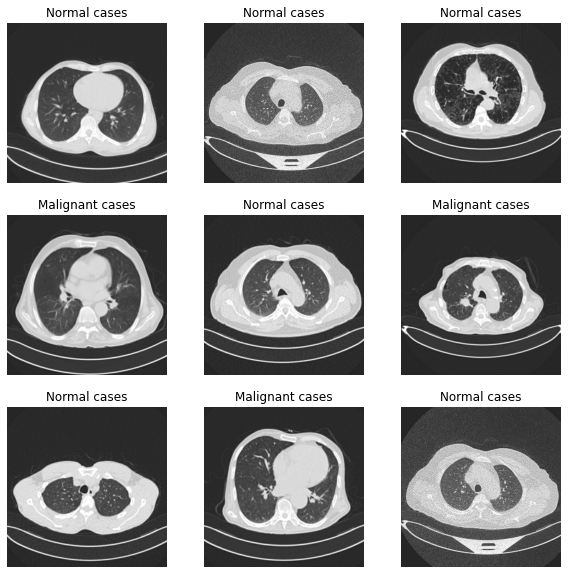

In [51]:
# visualiza the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [52]:
# We can also iterate over dataser as:

for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    labels_batch
    break

(256, 256, 256, 3)
(256,)


In [53]:
data = []
pa= os.getcwd()+'/data/ClassifiedData'
for i in class_names:
    path = os.path.join(pa, i)
    class_num = class_names.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, color_scale)  # here 1 shows rgb and 0 grayscale
        # preprocess here
        img = cv2.resize(img, (image_size, image_size))
        data.append([img, class_num])

random.shuffle(data)

In [54]:
x, y = [], []
for feature, label in data:
    x.append(feature)
    y.append(label)
    
x = np.array(x).reshape(-1, image_size, image_size, color_scale)
#x = x / 
y = np.array(y)
x.shape

(1097, 224, 224, 3)

### Split dataset

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio)


## Use data augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size), # May need to change this szie to augument data
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement MLP

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__()
        self.patch_size = patch_size
        
        

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [16]:
tf.shape(x_train)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([987, 224, 224,   3], dtype=int32)>

# Display patches for a sample image

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, color_scale))
    plt.imshow(patch_img.numpy().astype("uint16"))
    plt.axis("off")

### Patch encoder layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        

In [18]:
## LeNet-5
def LeNet5_custom(x):
    #x = layers.Conv2D(filters=6, kernel_size=5, activation='relu',padding='same')(x)
    #x = layers.Conv2D(filters=6, kernel_size=3, activation='relu',input_shape=(image_size, image_size, color_scale))(x)
    x = layers.Conv2D(filters=6, kernel_size=5, activation='relu')(x)
    x = layers.AveragePooling2D()(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
    x = layers.AveragePooling2D()(x)
    x = layers.Conv2D(filters=3, kernel_size=1, activation='relu')(x)
    return x

In [19]:
## pre-trained resnet network


def ResNet50_pre_trained(x, dropout_rate, num_top_trainable_layers=0):
    
    CNN1_layer = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same',activation='relu')
    
    pretrained_model_resnet50= ResNet50(input_shape=(image_size,image_size,color_scale),
                 include_top=True, pooling='avg', classes=num_classes_dataset, weights='imagenet')
    
    total_layers_count = pretrained_model_resnet50.layers.count
    count_layers = 0
    for each_layer in pretrained_model_resnet50.layers:
        count_layers += 1
        if (count_layers == total_layers_count-num_top_trainable_layers):
            break
        each_layer.trainable=False
    
    #x = CNN1_layer(x)
    x = pretrained_model_resnet50(x)
    #x = layers.Dropout(dropout_rate)(x)

    return x

## Build ViT model

In [20]:
def create_vit_classifier():
    
    inputs = layers.Input(shape=input_shape)
    
    # Augment data.
    augmented = data_augmentation(inputs)
    
    # CNN layer
    CNN_output = LeNet5_custom(augmented)
    
    # Create patches.
    patches = Patches(patch_size)(CNN_output)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train, and evaluate model

In [21]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")] )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        verbose=1)

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


## Load and prepare pretrained model on CIFAR-100

In [22]:

def change_model_top_layer(model, num_classes_new):
    # Input layer
    inputs_new = model.layers[0].input

    # Classify outputs(new top layer).
    logits_new = layers.Dense(num_classes_new, name='Dense_top')(model.layers[-2].output)
    
    # Create the Keras new model.
    model_updated = keras.Model(inputs=inputs_new, outputs=logits_new)
    
    return model_updated


In [23]:
def change_model_input_layer(model):
    # Input layer
    model_new = create_vit_classifier()
    
    for layer_count in range(len(model.layers)-1):
        if (0 != layer_count):
            model_new.layers[layer_count].set_weights(model.layers[layer_count].get_weights())
            
    return model_new

In [24]:
from tensorflow.keras.models import load_model

model_pretrained = load_model('CIFAR-100/saved_model/my_vit_CNN_model.keras', 
                       custom_objects={'PatchEncoder':PatchEncoder,
                                      'Patches':Patches})

In [25]:
model_pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 220, 220, 6)  456         ['data_augmentation[0][0]']      
                                                                                                  
 average_pooling2d (AveragePool  (None, 110, 110, 6)  0          ['conv2d[0][0]']                 
 ing2D)                                                                                       

                                                                                                  
 dropout_4 (Dropout)            (None, 81, 128)      0           ['dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 81, 64)       8256        ['dropout_4[0][0]']              
                                                                                                  
 dropout_5 (Dropout)            (None, 81, 64)       0           ['dense_6[0][0]']                
                                                                                                  
 add_5 (Add)                    (None, 81, 64)       0           ['dropout_5[0][0]',              
                                                                  'add_4[0][0]']                  
                                                                                                  
 layer_nor

 eadAttention)                                                    'layer_normalization_12[0][0]'] 
                                                                                                  
 add_12 (Add)                   (None, 81, 64)       0           ['multi_head_attention_6[0][0]', 
                                                                  'add_11[0][0]']                 
                                                                                                  
 layer_normalization_13 (LayerN  (None, 81, 64)      128         ['add_12[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_13 (Dense)               (None, 81, 128)      8320        ['layer_normalization_13[0][0]'] 
                                                                                                  
 dropout_1

 dropout_19 (Dropout)           (None, 81, 64)       0           ['dense_20[0][0]']               
                                                                                                  
 add_19 (Add)                   (None, 81, 64)       0           ['dropout_19[0][0]',             
                                                                  'add_18[0][0]']                 
                                                                                                  
 layer_normalization_20 (LayerN  (None, 81, 64)      128         ['add_19[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 81, 64)      99520       ['layer_normalization_20[0][0]', 
 HeadAttention)                                                   'layer_normalization_20[0][0]'] 
          

In [26]:
model_pretrained = change_model_input_layer(model_pretrained)

In [27]:
model_new = change_model_top_layer(model_pretrained, num_classes)
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 220, 220, 6)  456         ['data_augmentation[1][0]']      
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 110, 110, 6)  0          ['conv2d_3[0][0]']         

 dense_34 (Dense)               (None, 81, 128)      8320        ['layer_normalization_30[0][0]'] 
                                                                                                  
 dropout_43 (Dropout)           (None, 81, 128)      0           ['dense_34[0][0]']               
                                                                                                  
 dense_35 (Dense)               (None, 81, 64)       8256        ['dropout_43[0][0]']             
                                                                                                  
 dropout_44 (Dropout)           (None, 81, 64)       0           ['dense_35[0][0]']               
                                                                                                  
 add_29 (Add)                   (None, 81, 64)       0           ['dropout_44[0][0]',             
                                                                  'add_28[0][0]']                 
          

 multi_head_attention_18 (Multi  (None, 81, 64)      99520       ['layer_normalization_37[0][0]', 
 HeadAttention)                                                   'layer_normalization_37[0][0]'] 
                                                                                                  
 add_36 (Add)                   (None, 81, 64)       0           ['multi_head_attention_18[0][0]',
                                                                  'add_35[0][0]']                 
                                                                                                  
 layer_normalization_38 (LayerN  (None, 81, 64)      128         ['add_36[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_42 (Dense)               (None, 81, 128)      8320        ['layer_normalization_38[0][0]'] 
          

                                                                                                  
 dropout_58 (Dropout)           (None, 81, 64)       0           ['dense_49[0][0]']               
                                                                                                  
 add_43 (Add)                   (None, 81, 64)       0           ['dropout_58[0][0]',             
                                                                  'add_42[0][0]']                 
                                                                                                  
 layer_normalization_45 (LayerN  (None, 81, 64)      128         ['add_43[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_22 (Multi  (None, 81, 64)      99520       ['layer_normalization_45[0][0]', 
 HeadAtten

## Train the model

In [28]:
history = run_experiment(model_new)

Epoch 1/500
4/4 [==============================] - 17s 3s/step - loss: 1.1342 - accuracy: 0.4617 - top-5-accuracy: 1.0000 - val_loss: 0.8528 - val_accuracy: 0.6162 - val_top-5-accuracy: 1.0000
Epoch 2/500
4/4 [==============================] - 9s 2s/step - loss: 0.8330 - accuracy: 0.6318 - top-5-accuracy: 1.0000 - val_loss: 0.7426 - val_accuracy: 0.6667 - val_top-5-accuracy: 1.0000
Epoch 3/500
4/4 [==============================] - 9s 2s/step - loss: 0.7625 - accuracy: 0.6982 - top-5-accuracy: 1.0000 - val_loss: 0.6659 - val_accuracy: 0.7374 - val_top-5-accuracy: 1.0000
Epoch 4/500
4/4 [==============================] - 10s 2s/step - loss: 0.7099 - accuracy: 0.7038 - top-5-accuracy: 1.0000 - val_loss: 0.6129 - val_accuracy: 0.7475 - val_top-5-accuracy: 1.0000
Epoch 5/500
4/4 [==============================] - 11s 3s/step - loss: 0.6922 - accuracy: 0.7162 - top-5-accuracy: 1.0000 - val_loss: 0.6194 - val_accuracy: 0.7172 - val_top-5-accuracy: 1.0000
Epoch 6/500
4/4 [====================

Epoch 26/500
4/4 [==============================] - 9s 2s/step - loss: 0.2339 - accuracy: 0.9088 - top-5-accuracy: 1.0000 - val_loss: 0.2019 - val_accuracy: 0.9293 - val_top-5-accuracy: 1.0000
Epoch 27/500
4/4 [==============================] - 9s 2s/step - loss: 0.2144 - accuracy: 0.9200 - top-5-accuracy: 1.0000 - val_loss: 0.1885 - val_accuracy: 0.9293 - val_top-5-accuracy: 1.0000
Epoch 28/500
4/4 [==============================] - 9s 2s/step - loss: 0.1889 - accuracy: 0.9313 - top-5-accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 29/500
4/4 [==============================] - 9s 2s/step - loss: 0.1952 - accuracy: 0.9268 - top-5-accuracy: 1.0000 - val_loss: 0.1403 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 30/500
4/4 [==============================] - 9s 2s/step - loss: 0.1889 - accuracy: 0.9336 - top-5-accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 31/500
4/4 [=================

4/4 [==============================] - 9s 2s/step - loss: 0.0313 - accuracy: 0.9876 - top-5-accuracy: 1.0000 - val_loss: 0.1444 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 111/500
4/4 [==============================] - 9s 2s/step - loss: 0.0274 - accuracy: 0.9921 - top-5-accuracy: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 112/500
4/4 [==============================] - 9s 2s/step - loss: 0.0216 - accuracy: 0.9921 - top-5-accuracy: 1.0000 - val_loss: 0.1765 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 113/500
4/4 [==============================] - 9s 2s/step - loss: 0.0292 - accuracy: 0.9921 - top-5-accuracy: 1.0000 - val_loss: 0.2348 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 114/500
4/4 [==============================] - 9s 2s/step - loss: 0.0296 - accuracy: 0.9854 - top-5-accuracy: 1.0000 - val_loss: 0.1832 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 115/500
4/4 [=========================

4/4 [==============================] - 9s 2s/step - loss: 0.0243 - accuracy: 0.9910 - top-5-accuracy: 1.0000 - val_loss: 0.1065 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 195/500
4/4 [==============================] - 9s 2s/step - loss: 0.0159 - accuracy: 0.9921 - top-5-accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9697 - val_top-5-accuracy: 1.0000
Epoch 196/500
4/4 [==============================] - 9s 2s/step - loss: 0.0231 - accuracy: 0.9899 - top-5-accuracy: 1.0000 - val_loss: 0.1438 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 197/500
4/4 [==============================] - 9s 2s/step - loss: 0.0169 - accuracy: 0.9966 - top-5-accuracy: 1.0000 - val_loss: 0.2805 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 198/500
4/4 [==============================] - 9s 2s/step - loss: 0.0153 - accuracy: 0.9966 - top-5-accuracy: 1.0000 - val_loss: 0.2705 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 199/500
4/4 [=========================

4/4 [==============================] - 9s 2s/step - loss: 0.0164 - accuracy: 0.9944 - top-5-accuracy: 1.0000 - val_loss: 0.2379 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 279/500
4/4 [==============================] - 9s 2s/step - loss: 0.0067 - accuracy: 0.9989 - top-5-accuracy: 1.0000 - val_loss: 0.2985 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 280/500
4/4 [==============================] - 9s 2s/step - loss: 0.0222 - accuracy: 0.9932 - top-5-accuracy: 1.0000 - val_loss: 0.2993 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 281/500
4/4 [==============================] - 9s 2s/step - loss: 0.0148 - accuracy: 0.9955 - top-5-accuracy: 1.0000 - val_loss: 0.2529 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 282/500
4/4 [==============================] - 9s 2s/step - loss: 0.0214 - accuracy: 0.9955 - top-5-accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 283/500
4/4 [=========================

4/4 [==============================] - 9s 2s/step - loss: 0.0177 - accuracy: 0.9910 - top-5-accuracy: 1.0000 - val_loss: 0.1982 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 363/500
4/4 [==============================] - 9s 2s/step - loss: 0.0217 - accuracy: 0.9955 - top-5-accuracy: 1.0000 - val_loss: 0.0999 - val_accuracy: 0.9697 - val_top-5-accuracy: 1.0000
Epoch 364/500
4/4 [==============================] - 9s 2s/step - loss: 0.0121 - accuracy: 0.9944 - top-5-accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9697 - val_top-5-accuracy: 1.0000
Epoch 365/500
4/4 [==============================] - 9s 2s/step - loss: 0.0199 - accuracy: 0.9910 - top-5-accuracy: 1.0000 - val_loss: 0.1105 - val_accuracy: 0.9697 - val_top-5-accuracy: 1.0000
Epoch 366/500
4/4 [==============================] - 9s 2s/step - loss: 0.0113 - accuracy: 0.9944 - top-5-accuracy: 1.0000 - val_loss: 0.1689 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 367/500
4/4 [=========================

4/4 [==============================] - 9s 2s/step - loss: 0.0030 - accuracy: 1.0000 - top-5-accuracy: 1.0000 - val_loss: 0.4490 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 447/500
4/4 [==============================] - 9s 2s/step - loss: 0.0101 - accuracy: 0.9944 - top-5-accuracy: 1.0000 - val_loss: 0.4024 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 448/500
4/4 [==============================] - 9s 2s/step - loss: 0.0074 - accuracy: 0.9966 - top-5-accuracy: 1.0000 - val_loss: 0.3807 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 449/500
4/4 [==============================] - 9s 2s/step - loss: 0.0115 - accuracy: 0.9955 - top-5-accuracy: 1.0000 - val_loss: 0.4296 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 450/500
4/4 [==============================] - 9s 2s/step - loss: 0.0126 - accuracy: 0.9944 - top-5-accuracy: 1.0000 - val_loss: 0.4312 - val_accuracy: 0.9596 - val_top-5-accuracy: 1.0000
Epoch 451/500
4/4 [=========================

## Save the model

In [30]:
model_new.save('saved_model/Result/HViT4Lung_1.h5')
model_new.save('saved_model/Result/HViT4Lung_1.keras')

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])

In [41]:
accuracy_per_epoch_train = history.history['accuracy']
accuracy_per_epoch_val = history.history['val_accuracy']

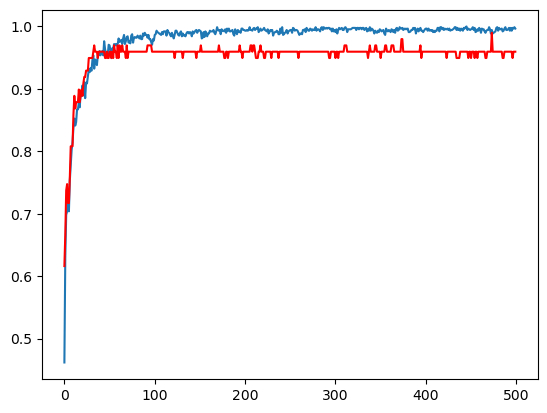

In [43]:
plt.plot(range(len(accuracy_per_epoch_train)), accuracy_per_epoch_train)
plt.plot(range(len(accuracy_per_epoch_val)), accuracy_per_epoch_val, 'r')

In [45]:
loss_per_epoch_train = history.history['loss']
loss_per_epoch_val = history.history['val_loss']

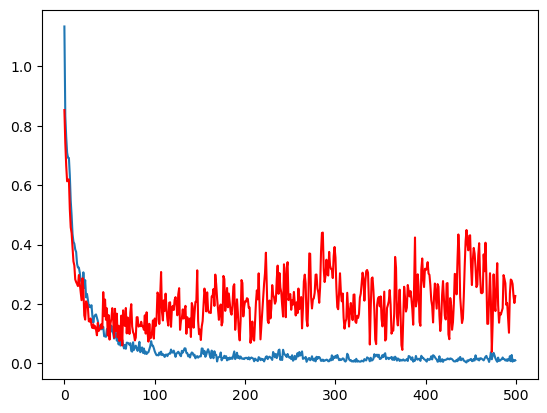

In [46]:
plt.plot(range(len(loss_per_epoch_train)), loss_per_epoch_train)
plt.plot(range(len(loss_per_epoch_val)), loss_per_epoch_val, 'r')

In [49]:
import pickle

with open('saved_model/Result/trainHistoryDict1', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [27]:
from tensorflow.keras.models import load_model

model1 = load_model('saved_model/Result/HViT4Lung_1.keras', 
                       custom_objects={'PatchEncoder':PatchEncoder,
                                      'Patches':Patches})

In [28]:
import pickle

with open('saved_model/Result/trainHistoryDict1', "rb") as file_pi:
    history = pickle.load(file_pi)

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio)

In [116]:
_, loss, accuracy, f1_score, precision, recall, accuracy, top_5_accuracy = model1.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

4/4 [==============================] - 2s 448ms/step - loss: 0.0536 - accuracy: 0.9909 - top-5-accuracy: 1.0000


ValueError: not enough values to unpack (expected 8, got 3)

In [89]:
y_test

array([1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0,
       2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 1,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1])

In [90]:
y_pred = model1.predict(x_test)

4/4 [==============================] - 2s 464ms/step


In [91]:
y_pred = y_pred.argmax(axis=1)

In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[13  0  1]
 [ 0 53  0]
 [ 0  0 43]]


In [100]:
class_names

['Bengin cases',
 'Malignant cases',
 'Normal cases',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',
 'Malignant',
 'Normal',
 'Bengin',

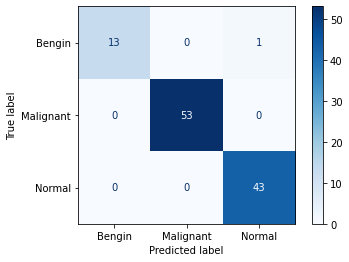

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = []
for item in class_names: 
    labels.append(item.split()[0])

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.savefig('saved_model/Result/Plots/ConfusionMatrix1.pdf', formatmat='pdf', bbox_inches = 'tight')
plt.show()

In [112]:
labels = []
for item in class_names: 
    labels.append(item.split()[0])
    
labels

['Bengin', 'Malignant', 'Normal']

In [97]:
x = 'reza roofegari'
x.split()[0]

'reza'

In [106]:
class_names

['Bengin cases', 'Malignant cases', 'Normal cases']

In [118]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

In [120]:
f1_score(y_test, y_pred, average=None)

array([0.96296296, 1.        , 0.98850575])

In [122]:
accuracy_score(y_test, y_pred, normalize=False)

109

In [123]:
from sklearn.metrics import classification_report

In [126]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Bengin     1.0000    0.9286    0.9630        14
   Malignant     1.0000    1.0000    1.0000        53
      Normal     0.9773    1.0000    0.9885        43

    accuracy                         0.9909       110
   macro avg     0.9924    0.9762    0.9838       110
weighted avg     0.9911    0.9909    0.9908       110

